# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.tensorboard import SummaryWriter

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
def get_mean_std(dataloader):

    mean=np.array([x[0].mean() for x in dataloader]).mean()
    std=np.array([x[0].std() for x in dataloader]).std()
    
    return mean,std

In [3]:
### load the data first so that the mean and the std can be calculated




def get_data(is_train=True):

    data = datasets.MNIST('../mnist_data', 
                         download=True, 
                         train=is_train,
                         transform=transforms.ToTensor())
    
    data = datasets.MNIST(root="data",
                   download=True,
                   train=is_train,
                   transform=transforms.Compose([transforms.ToTensor(), 
                                                 transforms.Normalize(get_mean_std(data)[0],
                                                                      get_mean_std(data)[1],
                                                                      inplace=True)]))

    return data


In [4]:
train_length= int(0.8*60000)
val_length= int(0.2*60000)
test_length= 10000

In [5]:
train_subset, val_subset = torch.utils.data.random_split(get_data(is_train=True), 
                                                         [train_length, val_length], 
                                                         generator=torch.Generator().manual_seed(42))


train_loader = torch.utils.data.DataLoader(dataset=train_subset,
                                           shuffle=True,
                                           batch_size=64)

val_loader = torch.utils.data.DataLoader(dataset=val_subset, 
                                         shuffle=False, 
                                         batch_size=64)

# Get test data

test_loader = torch.utils.data.DataLoader(get_data(is_train=False),
                                          batch_size=64)
                                            



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Summary of datasets: 

In [6]:
print("train dataset: length",len(train_loader.dataset),'\n')
print("validation dataset: length",len(val_loader.dataset),'\n')
print("test dataset:\n",test_loader.dataset)

train dataset: length 48000 

validation dataset: length 12000 

test dataset:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.1325145959854126, std=0.047720760107040405)
           )


## Preprocessing 

At the preprocessing stage it was not necessary to introduce transformations in order to prevent overfitting. 
Also, transformations such as random flipping could hurt the accuracy of the model, since we are classifying numbers.
Given that I was satisfied with the reached accuracy of ~98%, I did not try to intruduce any augmentation of the training set.

## Explore the Dataset


In [7]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        #print(images[i])
        #print(image.mode)
        plt.imshow(image.T.squeeze().T)
        plt.show()

7


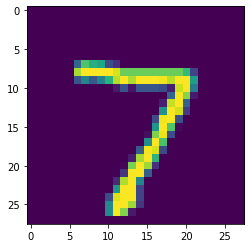

2


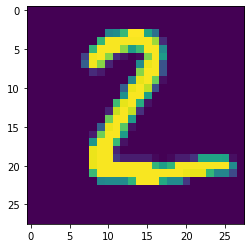

1


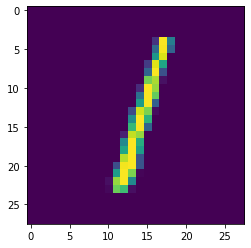

0


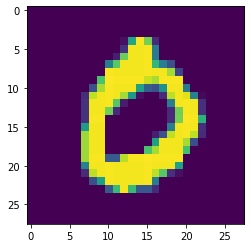

4


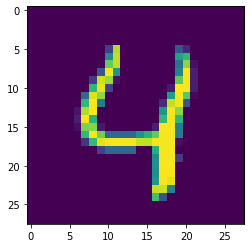

In [8]:
# Explore data
show5(test_loader)

## Architecture


I played around with different configurations. Increasing the number of hidden layers and neurons in each layers does not seem to help pushing accuracy beyond 98% on the validation set. 

For this reason I chose a simple architecture and added dropuout of neurons to prevent overfitting. 

In [9]:
# Define the class for your neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.dropout = nn.Dropout(0.25) 
        self.layer1 = nn.Linear(28*28,300)
        self.layer2 = nn.Linear(300,100)
        self.layer3 = nn.Linear(100,10)


    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = self.activation(self.layer1(x))
        x = self.dropout(x)
        x = self.activation(self.layer2(x))
        x = self.dropout(x)
        
        return self.layer3(x)



## Running the Neural Network


In [10]:
def training(num_epochs,optimizer,criterion,net,train_loader,val_loader,train_length,val_length):
    
    #check for GPU 
    if torch.cuda.is_available():
        # move tensor to CUDA
        device = torch.device("cuda")
        
    else:
        device = torch.device("cpu")

    net=net.to(device)
    
    
    
    #keep track of train and val loss:
    train_loss_history = list()
    val_loss_history = list()

    
    for epoch in range(num_epochs):
        
        net.train() # TRAIN MODE

        train_loss = 0.0
        train_correct = 0

        for i, data in enumerate(train_loader):

            
            # data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) 

            # Zero out the gradients of the optimizer
            optimizer.zero_grad()


            # Get the outputs of your model and compute your loss
            outputs = net(inputs)
            loss = criterion(outputs,labels)
            
            # Compute the loss gradient using the backward method and have the optimizer take a step
            loss.backward()
          
            
            # actually updates the weights, taking into account the learn rate and momentum:
            optimizer.step()

            # Compute the accuracy and print the accuracy and loss
            _, preds = torch.max(outputs.data, 1)
            train_correct += (preds == labels).sum().item()
            train_loss += loss.item()
        
        """
        In order to calculate the loss, given that loss.item() returns the running loss for the batch
        (it is already the mean of the loss for the batch) the cumulative sum has to be divided by the number of batches.
        """
        
        
        print(f'Epoch {epoch + 1} training accuracy: {train_correct/train_length:.2f}% training loss: {train_loss/len(train_loader)}')
        train_loss_history.append(train_loss/len(train_loader))

        
        ## Validation step... 
        
        with torch.no_grad():
        
            # Validation step 
            val_loss = 0.0
            val_correct = 0

            #validation mode
            net.eval()
            for inputs, labels in val_loader:

                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs).to(device)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs.data, 1)
                val_correct += (preds == labels).sum().item()
                val_loss += loss.item()


            print(f'Epoch {epoch + 1} validation accuracy: {val_correct/val_length:.2f}% validation loss: {val_loss/len(val_loader)}')
            val_loss_history.append(val_loss/len(val_loader))


    return net, train_loss_history, val_loss_history

net = Net()
optimizer = optim.Adam(net.parameters(), lr= 0.0015)
criterion = nn.CrossEntropyLoss()


epochs=20
net, train_loss_history, val_loss_history = training(epochs,
                                                     optimizer,
                                                     criterion,
                                                     net,
                                                     train_loader,
                                                     val_loader,
                                                     train_length,
                                                     val_length,
                                                     )    
    

Epoch 1 training accuracy: 0.89% training loss: 0.3698868486980597
Epoch 1 validation accuracy: 0.95% validation loss: 0.17376894439431897
Epoch 2 training accuracy: 0.93% training loss: 0.23323545028765996
Epoch 2 validation accuracy: 0.96% validation loss: 0.13987867417249908
Epoch 3 training accuracy: 0.94% training loss: 0.19858242709189652
Epoch 3 validation accuracy: 0.96% validation loss: 0.12228759338564062
Epoch 4 training accuracy: 0.95% training loss: 0.18277657264471053
Epoch 4 validation accuracy: 0.97% validation loss: 0.11888720248726771
Epoch 5 training accuracy: 0.95% training loss: 0.18043947409838437
Epoch 5 validation accuracy: 0.97% validation loss: 0.11830375288078125
Epoch 6 training accuracy: 0.95% training loss: 0.1645344877919803
Epoch 6 validation accuracy: 0.97% validation loss: 0.11721535270260845
Epoch 7 training accuracy: 0.95% training loss: 0.15785759307257832
Epoch 7 validation accuracy: 0.97% validation loss: 0.11316082838110308
Epoch 8 training accur

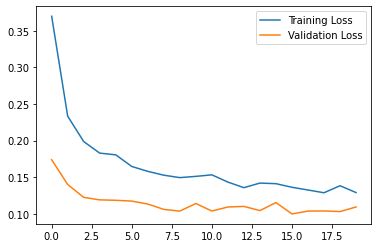

In [12]:
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

Based on the previous chart it is clear that the model is not overfitting. 

## Testing  model


In [21]:
def test_model(net,test_loader,test_length):
    
    """testing the model on testing data that has not been used during training."""
    
    #check for GPU 
    if torch.cuda.is_available():
        # move tensor to CUDA
        device = torch.device("cuda")
        
    else:
        device = torch.device("cpu")

    net=net.to(device)
    test_correct = 0
    
    for inputs, labels in test_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs).to(device)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        test_correct += (preds == labels).sum().item()
        
        
        
    
    print(f'test accuracy: {test_correct/test_length:.3f}')
    return round(test_correct/test_length,3)

In [22]:
accuracy=test_model(net,test_loader,test_length)

test accuracy: 0.977


### check random predictions vs labels:

In [15]:
def show_and_test(img_loader):
    
    
    
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    

    outputs = net(images.to(torch.device("cuda")))
    _, preds = torch.max(outputs.data, 1)
    
    for i in range(5):
        
        print("prediction:",preds[i].item(),"label:",int(labels[i].detach()))
    

In [16]:
show_and_test(test_loader)

prediction: 7 label: 7
prediction: 2 label: 2
prediction: 1 label: 1
prediction: 0 label: 0
prediction: 4 label: 4


### Show misclassified images:

In [23]:
def show_errors(img_loader):
    
    for batch in img_loader:
        
        labels = batch[1]
        images = batch[0]
        
        outputs = net(images.to(torch.device("cuda")))
        _, preds = torch.max(outputs.data, 1)
        
        for i in range(len(batch)):
            
            if preds[i]!=labels[i]:
                        
                        print("prediction:",preds[i].item(),"label:",labels[i].item())
                        image = images[i].numpy()
                        plt.imshow(image.T.squeeze().T)
                        plt.show()
            else:
                pass
                

prediction: 7 label: 2


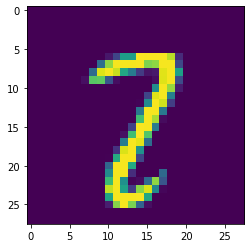

prediction: 9 label: 5


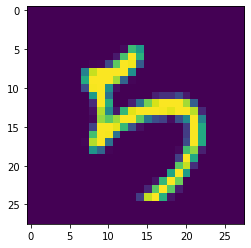

prediction: 1 label: 2


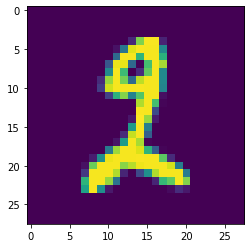

prediction: 2 label: 1


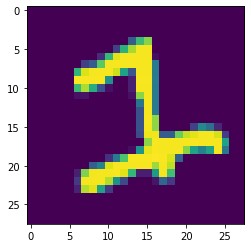

prediction: 4 label: 6


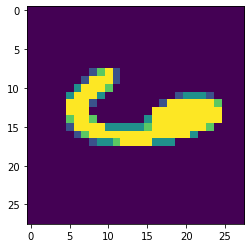

prediction: 8 label: 5


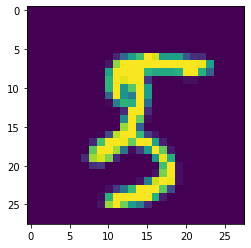

prediction: 7 label: 9


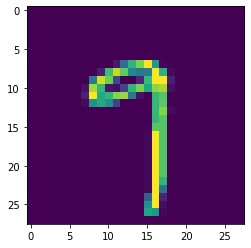

prediction: 7 label: 2


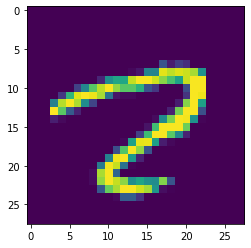

prediction: 0 label: 4


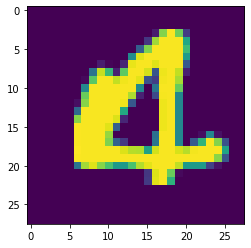

prediction: 7 label: 3


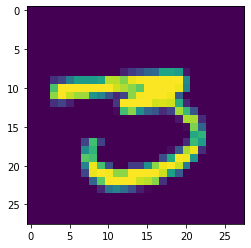

prediction: 2 label: 7


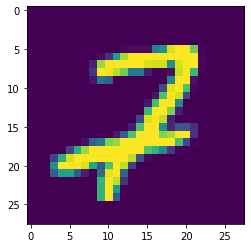

prediction: 7 label: 2


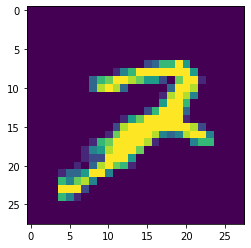

prediction: 6 label: 5


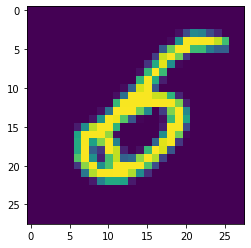

In [24]:
show_errors(test_loader)

In [25]:
state={
    
'epochs':epochs,
'model': net.state_dict(),
'best accuracy':f'{accuracy*100}%',
'optimizer':optimizer.state_dict()
}


torch.save(state,'model')